In [4]:
import sys
sys.path.insert(0,'../')
from libs.ssl_dataloader import *
from libs.ssl_model import *
from libs.ssl_utils import *
from libs.eeg_utils import *
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows)
from braindecode.datasets import BaseDataset, BaseConcatDataset, WindowsDataset
from braindecode.preprocessing.windowers import EEGWindowsDataset
from braindecode.datautil import load_concat_dataset
%load_ext autoreload
%autoreload 2
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

### Load raw data

In [4]:
datasets = []
releases = list(range(9,0,-1))
hbn_datasets = ['ds005514','ds005512','ds005511','ds005510','ds005509','ds005508','ds005507','ds005506','ds005505']
hbn_release_ds = dict(zip(releases,hbn_datasets))

In [7]:
ds1 = HBNDataset(hbn_release_ds[1], tasks=['RestingState'], num_workers=-1)
ds2 = HBNDataset(hbn_release_ds[6], tasks=['RestingState'], num_workers=-1)

KeyboardInterrupt: 

In [36]:
all_ds = BaseConcatDataset([ds1, ds2])

### Save to disk using braindecode

In [37]:
all_ds.save('data/hbn', overwrite=True)

Writing /home/dung/eeg-ssl/notebooks/data/hbn/0/0-raw.fif


Closing /home/dung/eeg-ssl/notebooks/data/hbn/0/0-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn/1/1-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn/1/1-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn/2/2-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn/2/2-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn/3/3-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn/3/3-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn/4/4-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn/4/4-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn/5/5-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn/5/5-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn/6/6-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn/6/6-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn/7/7-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn/7/7-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn/8/8-raw.fif
Closing /home/du

#### Load raw data from braindecode

In [19]:
loaded_dataset = load_concat_dataset(path='data/hbn', preload=False)
all_ds = loaded_dataset

### Visualize data sample

Effective window size : 4.096 (s)


(array([[0.0036655 , 0.00366356, 0.0036618 , ..., 0.00285055, 0.00284741,
        0.00284229]]), array([ 10.   ,  10.002,  10.004, ..., 352.21 , 352.212, 352.214]))
0.0028126064382113514 0.004163150380114056


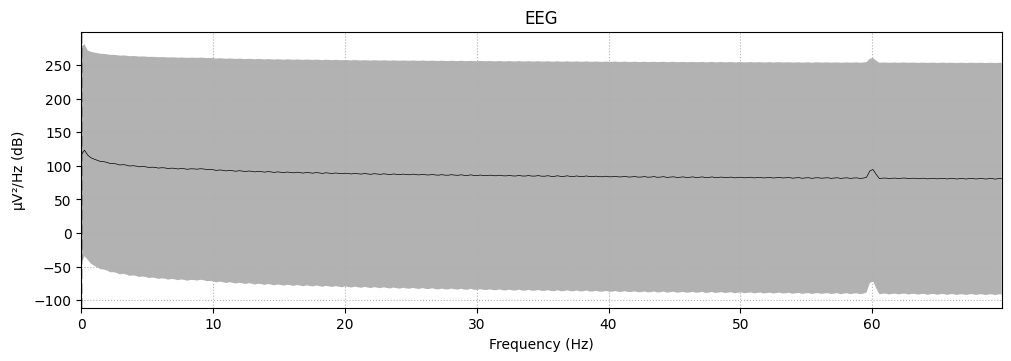

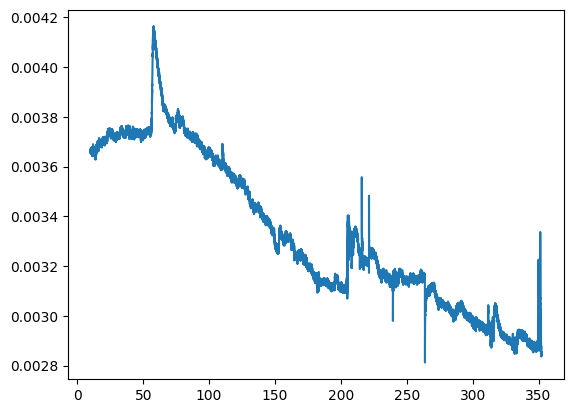

In [20]:
raw = all_ds.datasets[11].raw
fig = raw.compute_psd(fmax=70).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
sampling_freq = raw.info["sfreq"]
start_stop_seconds = np.array([10, 500])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)
x = raw_selection[1]
y = raw_selection[0].T
print(np.min(y),np.max(y))
plt.figure()
plt.plot(x, y)
plt.show()

### Preprocess data

In [ ]:
from numpy import multiply
sampling_rate = 250 # resample to follow the tutorial sampling rate
high_cut_hz = 30
# Factor to convert from V to uV
factor = 1e4
preprocessors = [
    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
    Preprocessor('crop', tmin=10),  # crop first 10 seconds as begining of noise recording
    Preprocessor('resample', sfreq=sampling_rate),
    Preprocessor('notch_filter', freqs=(60, 120)),
    Preprocessor('filter', l_freq=None, h_freq=high_cut_hz, n_jobs=-1)
]

# Transform the data
preprocess(all_ds, preprocessors)

In [ ]:
all_ds.save('data/hbn_preprocessed')

#### Load preprocessed data using braindecode

In [23]:
loaded_dataset = load_concat_dataset(path='data/hbn_preprocessed', preload=False)
all_ds = loaded_dataset
all_ds.datasets[0].description

task             RestingState
session                      
run                          
subject          NDARRD326KB9
sfreq                     500
age                   13.0092
sex                         F
ehq_total               57.83
p_factor               -0.648
attention              -0.055
internalizing          -0.051
externalizing          -0.109
dtype: object

Effective window size : 8.192 (s)


(array([[37.09259991, 37.09679191, 37.09481991, ..., 36.60017591,
        36.65189191, 36.71610791]]), array([10.   , 10.004, 10.008, ..., 99.988, 99.992, 99.996]))
35.91583190932124 41.60955589494597


/tmp/ipykernel_2313235/1978082691.py:2: UserWarning: Zero value in spectrum for channels E19, E86
  fig = raw.compute_psd(fmax=70).plot(
/tmp/ipykernel_2313235/1978082691.py:2: UserWarning: Infinite value in PSD for channels E19, E86.
These channels might be dead.
  fig = raw.compute_psd(fmax=70).plot(


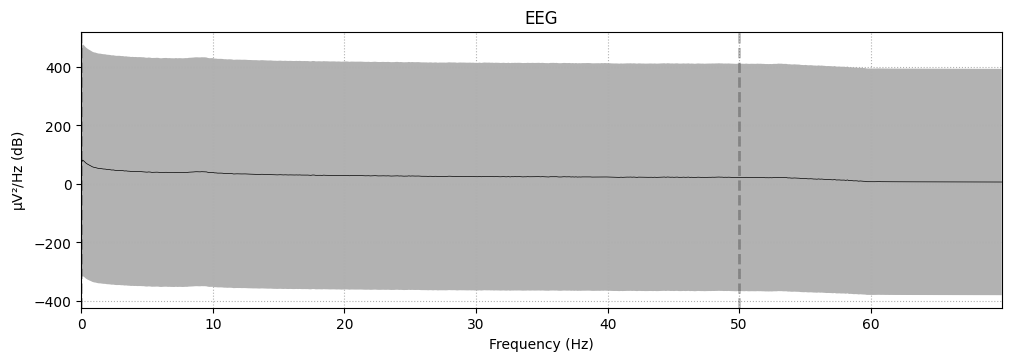

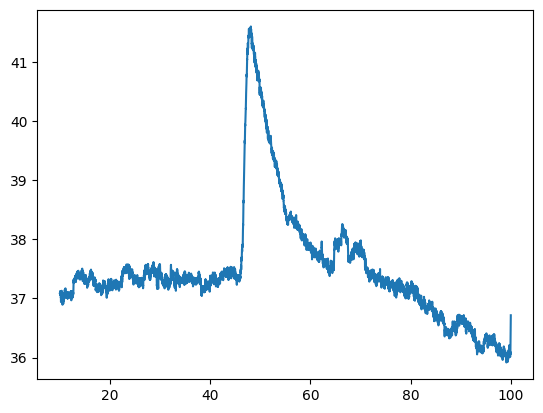

In [22]:
raw = all_ds.datasets[11].raw
fig = raw.compute_psd(fmax=70).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
sampling_freq = raw.info["sfreq"]
start_stop_seconds = np.array([10, 100])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)
x = raw_selection[1]
y = raw_selection[0].T
print(np.min(y),np.max(y))
plt.figure()
plt.plot(x, y)
plt.show()

### Set labels

In [24]:
target_name = 'age'
for ds in all_ds.datasets:
    ds.target_name = target_name

### Segment data windows

In [25]:
window_len_s = 10
fs = all_ds.datasets[0].raw.info['sfreq']
print('sampling rate', fs)
window_len_samples = int(fs * window_len_s)
window_stride_samples = int(fs * window_len_s) # non-overlapping
windows_ds = create_fixed_length_windows(
    all_ds, start_offset_samples=0, stop_offset_samples=None,
    window_size_samples=window_len_samples,
    window_stride_samples=window_stride_samples, drop_last_window=True,
    preload=False)

sampling rate 250.0


In [26]:
from sklearn.preprocessing import scale as standard_scale
preprocess(windows_ds, [Preprocessor(standard_scale, channel_wise=True)])

Reading 0 ... 85428  =      0.000 ...   341.712 secs...


Reading 0 ... 142127  =      0.000 ...   568.508 secs...
Reading 0 ... 85215  =      0.000 ...   340.860 secs...
Reading 0 ... 92214  =      0.000 ...   368.856 secs...
Reading 0 ... 84253  =      0.000 ...   337.012 secs...
Reading 0 ... 84677  =      0.000 ...   338.708 secs...
Reading 0 ... 85316  =      0.000 ...   341.264 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 89502  =      0.000 ...   358.008 secs...
Reading 0 ... 84815  =      0.000 ...   339.260 secs...
Reading 0 ... 89528  =      0.000 ...   358.112 secs...
Reading 0 ... 113237  =      0.000 ...   452.948 secs...
Reading 0 ... 85553  =      0.000 ...   342.212 secs...
Reading 0 ... 95489  =      0.000 ...   381.956 secs...
Reading 0 ... 84252  =      0.000 ...   337.008 secs...
Reading 0 ... 92013  =      0.000 ...   368.052 secs...
Reading 0 ... 104414  =      0.000 ...   417.656 secs...
Reading 0 ... 104976  =      0.000 ...   419.904 secs...
Reading 0 ... 180009  =      0.000 ...   720.036 secs...
Reading 0 ... 99538  =      0.000 ...   398.152 secs...
Reading 0 ... 103013  =      0.000 ...   412.052 secs...
Reading 0 ... 119212  =      0.000 ...   476.848 secs...
Reading 0 ... 98651  =      0.000 ...   394.604 secs...
Reading 0 ... 84115  =      0.000 ...   336.460 secs...
Reading 0 ... 161815  =      0.000 ...   647.260 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Reading 0 ... 94253  =      0.000 ...   377.012 secs...
Reading 0 ... 95901  =      0.000 ...   383.604 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The

Reading 0 ... 87753  =      0.000 ...   351.012 secs...
Reading 0 ... 85865  =      0.000 ...   343.460 secs...
Reading 0 ... 83728  =      0.000 ...   334.912 secs...
Reading 0 ... 96215  =      0.000 ...   384.860 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 90391  =      0.000 ...   361.564 secs...
Reading 0 ... 138207  =      0.000 ...   552.828 secs...
Reading 0 ... 120677  =      0.000 ...   482.708 secs...
Reading 0 ... 84153  =      0.000 ...   336.612 secs...
Reading 0 ... 84429  =      0.000 ...   337.716 secs...
Reading 0 ... 122326  =      0.000 ...   489.304 secs...
Reading 0 ... 89438  =      0.000 ...   357.752 secs...
Reading 0 ... 87025  =      0.000 ...   348.100 secs...
Reading 0 ... 86028  =      0.000 ...   344.112 secs...
Reading 0 ... 88175  =      0.000 ...   352.700 secs...
Reading 0 ... 150840  =      0.000 ...   603.360 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 108151  =      0.000 ...   432.604 secs...
Reading 0 ... 84053  =      0.000 ...   336.212 secs...
Reading 0 ... 88104  =      0.000 ...   352.416 secs...
Reading 0 ... 92913  =      0.000 ...   371.652 secs...
Reading 0 ... 86077  =      0.000 ...   344.308 secs...
Reading 0 ... 83741  =      0.000 ...   334.964 secs...
Reading 0 ... 93401  =      0.000 ...   373.604 secs...
Reading 0 ... 95591  =      0.000 ...   382.364 secs...
Reading 0 ... 84017  =      0.000 ...   336.068 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 86390  =      0.000 ...   345.560 secs...
Reading 0 ... 98367  =      0.000 ...   393.468 secs...
Reading 0 ... 91889  =      0.000 ...   367.556 secs...
Reading 0 ... 140357  =      0.000 ...   561.428 secs...
Reading 0 ... 85177  =      0.000 ...   340.708 secs...
Reading 0 ... 240231  =      0.000 ...   960.924 secs...
Reading 0 ... 104539  =      0.000 ...   418.156 secs...
Reading 0 ... 92177  =      0.000 ...   368.708 secs...
Reading 0 ... 136001  =      0.000 ...   544.004 secs...
Reading 0 ... 95488  =      0.000 ...   381.952 secs...
Reading 0 ... 83903  =      0.000 ...   335.612 secs...
Reading 0 ... 100213  =      0.000 ...   400.852 secs...
Reading 0 ... 108315  =      0.000 ...   433.260 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 84215  =      0.000 ...   336.860 secs...
Reading 0 ... 89928  =      0.000 ...   359.712 secs...
Reading 0 ... 84691  =      0.000 ...   338.764 secs...
Reading 0 ... 87465  =      0.000 ...   349.860 secs...
Reading 0 ... 92725  =      0.000 ...   370.900 secs...
Reading 0 ... 150427  =      0.000 ...   601.708 secs...
Reading 0 ... 96689  =      0.000 ...   386.756 secs...
Reading 0 ... 94524  =      0.000 ...   378.096 secs...
Reading 0 ... 85129  =      0.000 ...   340.516 secs...
Reading 0 ... 84317  =      0.000 ...   337.268 secs...
Reading 0 ... 84929  =      0.000 ...   339.716 secs...
Reading 0 ... 84178  =      0.000 ...   336.712 secs...
Reading 0 ... 249285  =      0.000 ...   997.140 secs...
Reading 0 ... 210085  =      0.000 ...   840.340 secs...
Reading 0 ... 83403  =      0.000 ...   333.612 secs...
Reading 0 ... 86204  =      0.000 ...   344.816 secs...
Reading 0 ... 90801  =      0.000 ...   363.204 secs...
Reading 0 ... 103939  =      0.000 ...   415.

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 97989  =      0.000 ...   391.956 secs...
Reading 0 ... 93877  =      0.000 ...   375.508 secs...
Reading 0 ... 136526  =      0.000 ...   546.104 secs...
Reading 0 ... 100950  =      0.000 ...   403.800 secs...
Reading 0 ... 99439  =      0.000 ...   397.756 secs...
Reading 0 ... 89152  =      0.000 ...   356.608 secs...
Reading 0 ... 88615  =      0.000 ...   354.460 secs...
Reading 0 ... 113838  =      0.000 ...   455.352 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 126536  =      0.000 ...   506.144 secs...
Reading 0 ... 84029  =      0.000 ...   336.116 secs...
Reading 0 ... 84627  =      0.000 ...   338.508 secs...
Reading 0 ... 131284  =      0.000 ...   525.136 secs...
Reading 0 ... 83855  =      0.000 ...   335.420 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 123601  =      0.000 ...   494.404 secs...
Reading 0 ... 85228  =      0.000 ...   340.912 secs...
Reading 0 ... 173603  =      0.000 ...   694.412 secs...
Reading 0 ... 117007  =      0.000 ...   468.028 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Reading 0 ... 97838  =      0.000 ...   391.352 secs...
Reading 0 ... 85353  =      0.000 ...   341.412 secs...
Reading 0 ... 97025  =      0.000 ...   388.100 secs...
Reading 0 ... 145262  =      0.000 ...   581.048 secs...
Reading 0 ... 100189  =      0.000 ...   400.756 secs...
Reading 0 ... 89889  =      0.000 ...   359.556 secs...
Reading 0 ... 108802  =      0.000 ...   435.208 secs...
Reading 0 ... 99763  =      0.000 ...   399.052 secs...
Reading 0 ... 95763  =      0.000 ...   383.052 secs...
Reading 0 ... 129799  =      0.000 ...   519.196 secs...
Reading 0 ... 83677  =      0.000 ...   334.708 secs...
Reading 0 ... 95001  =      0.000 ...   380.004 secs...
Reading 0 ... 83316  =      0.000 ...   333.264 secs...
Reading 0 ... 146005  =      0.000 ...   584.020 secs...
Reading 0 ... 88040  =      0.000 ...   352.160 secs...
Reading 0 ... 86366  =      0.000 ...   345.464 secs...
Reading 0 ... 87803  =      0.000 ...   351.212 secs...
Reading 0 ... 85378  =      0.000 ...   341

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Reading 0 ... 249103  =      0.000 ...   996.412 secs...
Reading 0 ... 84791  =      0.000 ...   339.164 secs...
Reading 0 ... 94513  =      0.000 ...   378.052 secs...
Reading 0 ... 84666  =      0.000 ...   338.664 secs...
Reading 0 ... 93275  =      0.000 ...   373.100 secs...
Reading 0 ... 100751  =      0.000 ...   403.004 secs...
Reading 0 ... 84090  =      0.000 ...   336.360 secs...
Reading 0 ... 106251  =      0.000 ...   425.004 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 85565  =      0.000 ...   342.260 secs...
Reading 0 ... 92001  =      0.000 ...   368.004 secs...
Reading 0 ... 92865  =      0.000 ...   371.460 secs...
Reading 0 ... 87615  =      0.000 ...   350.460 secs...
Reading 0 ... 100026  =      0.000 ...   400.104 secs...
Reading 0 ... 102477  =      0.000 ...   409.908 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 175955  =      0.000 ...   703.820 secs...
Reading 0 ... 84279  =      0.000 ...   337.116 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Reading 0 ... 87991  =      0.000 ...   351.964 secs...
Reading 0 ... 85451  =      0.000 ...   341.804 secs...
Reading 0 ... 86101  =      0.000 ...   344.404 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 87080  =      0.000 ...   348.320 secs...
Reading 0 ... 113128  =      0.000 ...   452.512 secs...
Reading 0 ... 90775  =      0.000 ...   363.100 secs...
Reading 0 ... 115401  =      0.000 ...   461.604 secs...
Reading 0 ... 85651  =      0.000 ...   342.604 secs...
Reading 0 ... 86243  =      0.000 ...   344.972 secs...
Reading 0 ... 87076  =      0.000 ...   348.304 secs...
Reading 0 ... 86126  =      0.000 ...   344.504 secs...
Reading 0 ... 86863  =      0.000 ...   347.452 secs...
Reading 0 ... 117301  =      0.000 ...   469.204 secs...
Reading 0 ... 106966  =      0.000 ...   427.864 secs...
Reading 0 ... 114489  =      0.000 ...   457.956 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 85305  =      0.000 ...   341.220 secs...
Reading 0 ... 114463  =      0.000 ...   457.852 secs...
Reading 0 ... 102451  =      0.000 ...   409.804 secs...
Reading 0 ... 87137  =      0.000 ...   348.548 secs...
Reading 0 ... 98451  =      0.000 ...   393.804 secs...
Reading 0 ... 96451  =      0.000 ...   385.804 secs...
Reading 0 ... 89439  =      0.000 ...   357.756 secs...
Reading 0 ... 100539  =      0.000 ...   402.156 secs...
Reading 0 ... 97091  =      0.000 ...   388.364 secs...
Reading 0 ... 97226  =      0.000 ...   388.904 secs...
Reading 0 ... 88266  =      0.000 ...   353.064 secs...
Reading 0 ... 84278  =      0.000 ...   337.112 secs...
Reading 0 ... 105953  =      0.000 ...   423.812 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Reading 0 ... 108537  =      0.000 ...   434.148 secs...
Reading 0 ... 128803  =      0.000 ...   515.212 secs...
Reading 0 ... 83467  =      0.000 ...   333.868 secs...
Reading 0 ... 92276  =      0.000 ...   369.104 secs...
Reading 0 ... 83980  =      0.000 ...   335.920 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 123831  =      0.000 ...   495.324 secs...
Reading 0 ... 88013  =      0.000 ...   352.052 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 86662  =      0.000 ...   346.648 secs...
Reading 0 ... 87651  =      0.000 ...   350.604 secs...
Reading 0 ... 95451  =      0.000 ...   381.804 secs...
Reading 0 ... 87388  =      0.000 ...   349.552 secs...
Reading 0 ... 86192  =      0.000 ...   344.768 secs...
Reading 0 ... 86439  =      0.000 ...   345.756 secs...
Reading 0 ... 85812  =      0.000 ...   343.248 secs...
Reading 0 ... 90150  =      0.000 ...   360.600 secs...
Reading 0 ... 87163  =      0.000 ...   348.652 secs...
Reading 0 ... 82967  =      0.000 ...   331.868 secs...
Reading 0 ... 87489  =      0.000 ...   349.956 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 87451  =      0.000 ...   349.804 secs...
Reading 0 ... 91363  =      0.000 ...   365.452 secs...
Reading 0 ... 87626  =      0.000 ...   350.504 secs...
Reading 0 ... 112615  =      0.000 ...   450.460 secs...
Reading 0 ... 100089  =      0.000 ...   400.356 secs...
Reading 0 ... 85617  =      0.000 ...   342.468 secs...
Reading 0 ... 107051  =      0.000 ...   428.204 secs...
Reading 0 ... 85938  =      0.000 ...   343.752 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 87029  =      0.000 ...   348.116 secs...
Reading 0 ... 84530  =      0.000 ...   338.120 secs...
Reading 0 ... 91975  =      0.000 ...   367.900 secs...
Reading 0 ... 96013  =      0.000 ...   384.052 secs...
Reading 0 ... 84430  =      0.000 ...   337.720 secs...
Reading 0 ... 113477  =      0.000 ...   453.908 secs...
Reading 0 ... 158883  =      0.000 ...   635.532 secs...
Reading 0 ... 103026  =      0.000 ...   412.104 secs...
Reading 0 ... 112026  =      0.000 ...   448.104 secs...
Reading 0 ... 87163  =      0.000 ...   348.652 secs...
Reading 0 ... 84843  =      0.000 ...   339.372 secs...
Reading 0 ... 88863  =      0.000 ...   355.452 secs...
Reading 0 ... 118239  =      0.000 ...   472.956 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 88087  =      0.000 ...   352.348 secs...
Reading 0 ... 86213  =      0.000 ...   344.852 secs...
Reading 0 ... 134827  =      0.000 ...   539.308 secs...
Reading 0 ... 111701  =      0.000 ...   446.804 secs...
Reading 0 ... 85450  =      0.000 ...   341.800 secs...
Reading 0 ... 85438  =      0.000 ...   341.752 secs...
Reading 0 ... 84541  =      0.000 ...   338.164 secs...
Reading 0 ... 100951  =      0.000 ...   403.804 secs...
Reading 0 ... 85693  =      0.000 ...   342.772 secs...
Reading 0 ... 85303  =      0.000 ...   341.212 secs...
Reading 0 ... 105254  =      0.000 ...   421.016 secs...
Reading 0 ... 83555  =      0.000 ...   334.220 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Reading 0 ... 89525  =      0.000 ...   358.100 secs...
Reading 0 ... 85150  =      0.000 ...   340.600 secs...
Reading 0 ... 95530  =      0.000 ...   382.120 secs...
Reading 0 ... 83079  =      0.000 ...   332.316 secs...
Reading 0 ... 84231  =      0.000 ...   336.924 secs...
Reading 0 ... 91239  =      0.000 ...   364.956 secs...
Reading 0 ... 98059  =      0.000 ...   392.236 secs...
Reading 0 ... 88188  =      0.000 ...   352.752 secs...
Reading 0 ... 87291  =      0.000 ...   349.164 secs...
Reading 0 ... 95679  =      0.000 ...   382.716 secs...
Reading 0 ... 85588  =      0.000 ...   342.352 secs...
Reading 0 ... 103351  =      0.000 ...   413.404 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Reading 0 ... 88363  =      0.000 ...   353.452 secs...
Reading 0 ... 211283  =      0.000 ...   845.132 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 88625  =      0.000 ...   354.500 secs...
Reading 0 ... 89939  =      0.000 ...   359.756 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Reading 0 ... 105427  =      0.000 ...   421.708 secs...
Reading 0 ... 154461  =      0.000 ...   617.844 secs...
Reading 0 ... 98101  =      0.000 ...   392.404 secs...
Reading 0 ... 141226  =      0.000 ...   564.904 secs...
Reading 0 ... 85550  =      0.000 ...   342.200 secs...
Reading 0 ... 101138  =      0.000 ...   404.552 secs...
Reading 0 ... 89417  =      0.000 ...   357.668 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 83693  =      0.000 ...   334.772 secs...
Reading 0 ... 83719  =      0.000 ...   334.876 secs...
Reading 0 ... 84304  =      0.000 ...   337.216 secs...
Reading 0 ... 84505  =      0.000 ...   338.020 secs...
Reading 0 ... 84355  =      0.000 ...   337.420 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 83193  =      0.000 ...   332.772 secs...
Reading 0 ... 100251  =      0.000 ...   401.004 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 94675  =      0.000 ...   378.700 secs...
Reading 0 ... 83642  =      0.000 ...   334.568 secs...
Reading 0 ... 139623  =      0.000 ...   558.492 secs...
Reading 0 ... 88063  =      0.000 ...   352.252 secs...
Reading 0 ... 85688  =      0.000 ...   342.752 secs...
Reading 0 ... 84226  =      0.000 ...   336.904 secs...
Reading 0 ... 85389  =      0.000 ...   341.556 secs...
Reading 0 ... 94167  =      0.000 ...   376.668 secs...
Reading 0 ... 94113  =      0.000 ...   376.452 secs...
Reading 0 ... 86113  =      0.000 ...   344.452 secs...
Reading 0 ... 108176  =      0.000 ...   432.704 secs...
Reading 0 ... 82755  =      0.000 ...   331.020 secs...
Reading 0 ... 90976  =      0.000 ...   363.904 secs...
Reading 0 ... 83817  =      0.000 ...   335.268 secs...
Reading 0 ... 84105  =      0.000 ...   336.420 secs...
Reading 0 ... 82867  =      0.000 ...   331.468 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Reading 0 ... 109551  =      0.000 ...   438.204 secs...
Reading 0 ... 103977  =      0.000 ...   415.908 secs...
Reading 0 ... 105901  =      0.000 ...   423.604 secs...
Reading 0 ... 102775  =      0.000 ...   411.100 secs...
Reading 0 ... 84642  =      0.000 ...   338.568 secs...
Reading 0 ... 85975  =      0.000 ...   343.900 secs...
Reading 0 ... 84593  =      0.000 ...   338.372 secs...
Reading 0 ... 100551  =      0.000 ...   402.204 secs...
Reading 0 ... 104113  =      0.000 ...   416.452 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Reading 0 ... 85956  =      0.000 ...   343.824 secs...
Reading 0 ... 90738  =      0.000 ...   362.952 secs...


In [28]:
windows_ds.save('data/hbn_preprocessed_windowed_scaled')

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/0/0-raw.fif


Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/0/0-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/1/1-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/1/1-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/2/2-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/2/2-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/3/3-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/3/3-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/4/4-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/4/4-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/5/5-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/5/5-raw.fif
[done]
W

#### Load segmented data windows

In [5]:
window_len_s = 10

In [6]:
windows_ds = load_concat_dataset(path='data/hbn_preprocessed_windowed_scaled', preload=False)

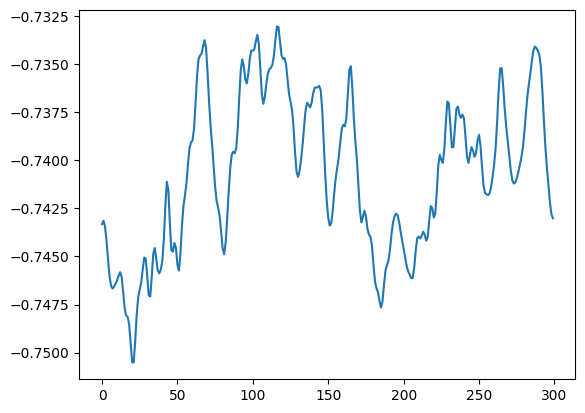

In [7]:
sample_range = list(range(300))
plt.plot(sample_range, windows_ds[100][0][0,sample_range])
plt.show()

### Train-test split

In [8]:
random_state = 87
n_jobs = -1

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from braindecode.datasets import BaseConcatDataset

subjects = np.unique(windows_ds.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)

In [10]:
# class RelativePositioningDataset(BaseConcatDataset):
#     """BaseConcatDataset with __getitem__ that expects 2 indices and a target.
#     """

#     def __init__(self, list_of_ds):
#         super().__init__(list_of_ds)
#         self.return_pair = True

#     def __getitem__(self, index):
#         if self.return_pair:
#             ind1, ind2, y = index
#             return (super().__getitem__(ind1)[0],
#                     super().__getitem__(ind2)[0]), y
#         else:
#             return super().__getitem__(index)

#     @property
#     def return_pair(self):
#         return self._return_pair

#     @return_pair.setter
#     def return_pair(self, value):
#         self._return_pair = value

split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = RelativePositioningDataset(
        [ds for ds in windows_ds.datasets
         if ds.description['subject'] in values])


In [11]:
print('train datasets', len(splitted['train'].datasets))
print('validation datasets', len(splitted['valid'].datasets))
print('test datasets', len(splitted['test'].datasets))
splitted['train'].get_metadata()

train datasets 162
validation datasets 54
test datasets 55


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:514: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_dfs)


,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,task,session,run,subject,sfreq,age,sex,ehq_total,p_factor,attention,internalizing,externalizing
0,0,0,2500,7.6979,RestingState,,,NDARZD415ZZ1,500,7.6979,M,93.38,-0.66,0.786,0.657,-0.398
1,1,2500,5000,7.6979,RestingState,,,NDARZD415ZZ1,500,7.6979,M,93.38,-0.66,0.786,0.657,-0.398
2,2,5000,7500,7.6979,RestingState,,,NDARZD415ZZ1,500,7.6979,M,93.38,-0.66,0.786,0.657,-0.398
3,3,7500,10000,7.6979,RestingState,,,NDARZD415ZZ1,500,7.6979,M,93.38,-0.66,0.786,0.657,-0.398
4,4,10000,12500,7.6979,RestingState,,,NDARZD415ZZ1,500,7.6979,M,93.38,-0.66,0.786,0.657,-0.398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,29,72500,75000,5.4358,RestingState,,,NDARTH433TE0,500,5.4358,M,100.05,0.94,-0.637,-0.349,1.055
30,30,75000,77500,5.4358,RestingState,,,NDARTH433TE0,500,5.4358,M,100.05,0.94,-0.637,-0.349,1.055
31,31,77500,80000,5.4358,RestingState,,,NDARTH433TE0,500,5.4358,M,100.05,0.94,-0.637,-0.349,1.055
32,32,80000,82500,5.4358,RestingState,,,NDARTH433TE0,500,5.4358,M,100.05,0.94,-0.637,-0.349,1.055


In [12]:
from braindecode.samplers import RelativePositioningSampler

sfreq = 250
tau_pos, tau_neg = int(sfreq * 10), int(sfreq * 2 * 10)
n_examples_train = 250 * len(splitted['train'].datasets)
n_examples_valid = 250 * len(splitted['valid'].datasets)
n_examples_test = 250 * len(splitted['test'].datasets)

train_sampler = RelativePositioningSampler(
    splitted['train'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_train, same_rec_neg=False, random_state=random_state)
valid_sampler = RelativePositioningSampler(
    splitted['valid'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_valid, same_rec_neg=False,
    random_state=random_state).presample()
test_sampler = RelativePositioningSampler(
    splitted['test'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_test, same_rec_neg=False,
    random_state=random_state).presample()

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:514: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_dfs)
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:514: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_dfs)
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:514: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depre

### Specify and train model with Torch Lightning

In [15]:
import lightning as L
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet
# define the LightningModule
class LitSSL(L.LightningModule):
    def __init__(self, n_channels, sfreq, input_size_samples, window_len_s, emb_size, dropout=0.5):
        super().__init__()
        self.emb = self.create_embedding_layer(n_channels, sfreq, input_size_samples, window_len_s) #VGGSSL()
        self.pooling = nn.AdaptiveAvgPool2d(32)
        self.clf = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(1024, emb_size),
            nn.Dropout(dropout),
            nn.Linear(emb_size, 1)
        )

    def create_embedding_layer(self, n_channels, sfreq, input_size_samples, window_len_s):
        return ShallowFBCSPNet(
            n_chans=n_channels,
            sfreq=sfreq,
            n_outputs=emb_size,
            # n_conv_chs=16,
            n_times=input_size_samples,
            input_window_seconds=window_len_s,
            # dropout=0,
            # apply_batch_norm=True,
        )

    def embed(self, x):
        z = self.clf[1](self.pooling(self.emb(x)).flatten(start_dim=1))
        return z

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        self.emb.train()
        X, y = batch
        x1, x2 = X[0], X[1]
        z1, z2 = self.emb(x1), self.emb(x2)
        z = self.pooling(torch.abs(z1 - z2)).flatten(start_dim=1)

        loss = nn.functional.binary_cross_entropy_with_logits(self.clf(z).flatten(), y)

        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        from sklearn import linear_model
        regr = linear_model.LinearRegression()
        X, Y, _ = batch
        z = self.embed(X).detach().cpu().numpy()
        Y = Y.detach().cpu().numpy()
        isnan = np.isnan(Y)
        embs = z[~isnan]
        labels = Y[~isnan]
        regr.fit(embs, labels)
        score = regr.score(embs, labels) 
        self.log('val_score', score)
        

    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_ds[0][0].shape
emb_size = 100
classes = list(range(5))

model = LitSSL(n_channels, sfreq, input_size_samples, window_len_s, emb_size)

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [16]:
train_loader = DataLoader(splitted['train'], sampler=train_sampler, batch_size=128, num_workers=4)
splitted['valid'].return_pair = False
val_loader = DataLoader(splitted['valid'], batch_size=128, num_workers=4)
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(max_epochs=1, accelerator='gpu')
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader) #, ckpt_path="lightning_logs/version_10/checkpoints/epoch=199-step=20000.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | emb     | ShallowFBCSPNet   | 327 K  | eval 
1 | pooling | AdaptiveAvgPool2d | 0      | train
2 | clf     | Sequential        | 102 K  | train
------------------------------------------------------
430 K     Trainable params
0         Non-trainable params
430 K     Total params
1.721     Total estimated model params size (MB)
10        Modules in train mode
11        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 317/317 [00:36<00:00,  8.75it/s, v_num=7]        

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 317/317 [00:36<00:00,  8.75it/s, v_num=7]


In [64]:
# Load the TensorBoard notebook extension
%load_ext tensorboard